In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse

In [3]:
from scipy.stats import gaussian_kde

In [4]:
np.random.seed(6)

In [5]:
# Hyperparameters
K = 4
d = 2
n = 400
r = np.ones((K,)) / float(K)
alpha = 20.0
beta = 1.0
gamma = 1.0

In [6]:
# Simulate a dataset
c_true = np.random.choice(np.arange(K), p=r, size=(n,))
mu_true = np.random.normal(0, alpha, size=(K, d))
sigma_true = np.random.lognormal(beta, gamma, size=(K, d))

data = []
for i in range(n):
    c = c_true[i]
    mu = mu_true[c, :]
    sigma = np.diag(sigma_true[c, :]**2)
    obs = np.random.multivariate_normal(mu, sigma)
    data.append(obs)
data = np.array(data)

In [ ]:
colors = ['red', 'green', 'blue', 'cyan']

In [64]:
def display_cluster_results(data, labels, mu, sigma, ax = None):
    if ax is None:
        fig, ax = plt.subplots()

    for k in range(K):
        mask = (labels == k)
        x, y = data[mask, :].transpose()
        ax.plot(x, y, '.', color=colors[k], zorder=k)

    for k in range(K):
        e = Ellipse(xy = mu[k], width=4*sigma[k,0], height=4*sigma[k,1], alpha=0.3, facecolor='gray', edgecolor='none')
        ax.add_artist(e)

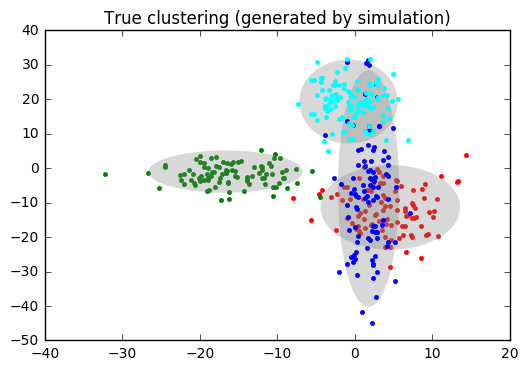

In [65]:
display_cluster_results(data, labels=c_true, mu=mu_true, sigma=sigma_true)
plt.gca().set_title("True clustering (generated by simulation)")
None

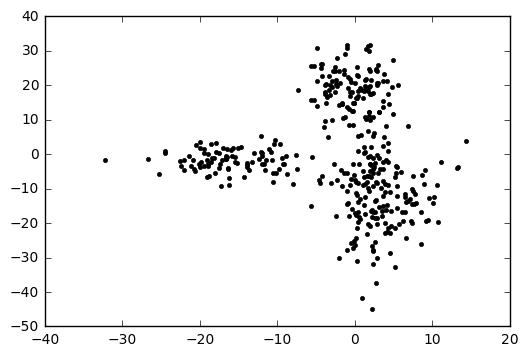

In [186]:
plt.plot(data[:,0], data[:,1], 'k.')
None

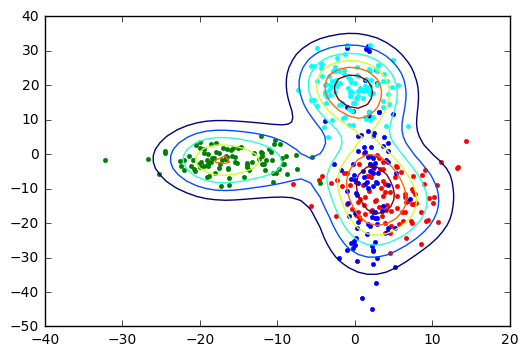

In [66]:
fig, ax = plt.subplots()
for k in range(K):
    mask = (c_true == k)
    x, y = data[mask, :].transpose()
    ax.plot(x, y, '.', color=colors[k], zorder=k)

# Use kernel density estimation
density = gaussian_kde(data.transpose())

x = np.linspace(*(ax.get_xlim() + (50,)))
y = np.linspace(*(ax.get_ylim() + (50,)))
x, y = np.meshgrid(x, y)
grid = np.vstack([x.ravel(), y.ravel()])

z = np.reshape(density.evaluate(grid), x.shape)

ax.contour(x, y, z, zorder=K+1)

None

In [67]:
def normalize_by_row(X):
    denom = X.sum(axis = 1, keepdims = True)
    result = np.true_divide(X, denom)
    return result

In [171]:
def variational_inference(data, num_iters=1000):
    data = np.asarray(data)

    history = {"m": [], "s2": [], "a": [], "b2": [], "phi": []}
    
    # Initialize variational parameters
    m = np.random.normal(0, 1, size=(K, d))
    s2 = np.ones((K, d))
    a = np.random.normal(0, 1, size=(K, d))
    b2 = np.ones((K, d))
    phi = normalize_by_row(np.random.uniform(0, 1, (n, K)))

    def update_history():
        _ = history
        history["m"].append(m.copy())
        history["s2"].append(s2.copy())
        history["a"].append(a.copy())
        history["b2"].append(b2.copy())
        history["phi"].append(phi.copy())
        
    update_history()
    
    for iter_index in range(num_iters):
        for i in range(n):
            for k in range(K):
                foo = np.exp(2*b2[k] - 2*a[k])
                phi[i, k] = r[k] * np.exp(-np.sum(
                    a[k]
                    - 0.5 * data[i] ** 2 * foo
                    + data[i] * foo * m[k]
                    - 0.5 * foo * (m[k]**2 + s2[k])))
        phi = normalize_by_row(phi)
        for k in range(K):
            foo = np.exp(2*b2[k] - 2*a[k])
            denom = 1.0 / alpha ** 2 + foo * np.sum(phi[:,k])
            m[k] = foo * np.sum(phi[:, k, np.newaxis] * data) / denom
            s2[k] = 1 / denom

        for k in range(K):
            a[k] = beta - gamma**2 * np.sum(phi[:,k]) - gamma**2
            b2[k] = gamma**2

        update_history()

    return m, s2, a, b2, phi, history

In [172]:
%%time
m, s2, a, b2, phi, history = variational_inference(data, num_iters=20)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


CPU times: user 590 ms, sys: 13.9 ms, total: 604 ms
Wall time: 596 ms


In [173]:
print m
print s2
print a
print b2
print phi

[[ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]]
[[ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]]
[[ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]]
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 ..., 
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]


In [174]:
corrected_permutation = np.array([np.argmin(np.abs(m[i] - mu_true)) for i in range(len(m))])
corrected_permutation

array([0, 0, 0, 0])

In [175]:
inv_corrected_permutation = np.zeros(K, dtype='int')
inv_corrected_permutation[corrected_permutation] = np.arange(K)
inv_corrected_permutation

array([3, 0, 0, 0])

In [176]:
pred_labels = np.argmax(phi, axis=1)

In [177]:
confusion_matrix = np.zeros((K, K))
for i in range(len(c_true)):
    #confusion_matrix[labels[i], corrected_permutation[pred_labels[i]]] += 1
    confusion_matrix[c_true[i], pred_labels[i]] += 1

confusion_matrix

array([[  97.,    0.,    0.,    0.],
       [  95.,    0.,    0.,    0.],
       [ 100.,    0.,    0.,    0.],
       [ 108.,    0.,    0.,    0.]])

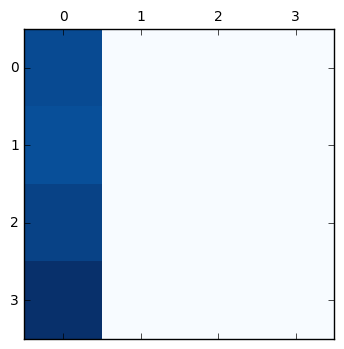

In [178]:
plt.matshow(confusion_matrix, cmap='Blues', vmin=0, vmax=np.max(confusion_matrix))
None

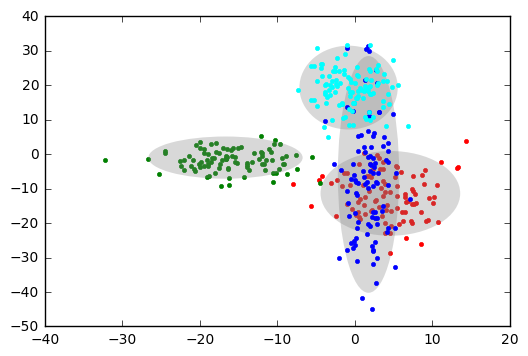

In [179]:
display_cluster_results(data, c_true, mu_true, sigma_true)

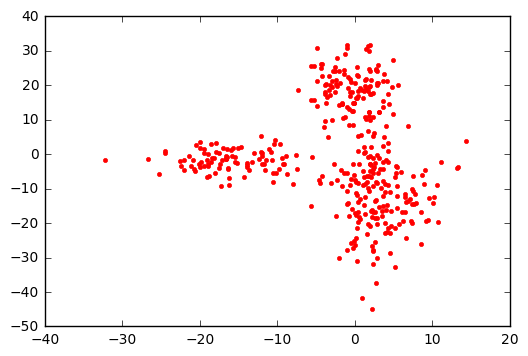

In [180]:
display_cluster_results(data, pred_labels, m, np.sqrt(s2))

In [181]:
from matplotlib.animation import FuncAnimation

In [182]:
fig, ax = plt.subplots()
def update(i):
    ax.clear()
    current_phi = history["phi"][i]
    current_pred = np.argmax(current_phi, axis=1)
    display_cluster_results(data, current_pred, history["m"][i], np.sqrt(history["s2"][i]), ax)
frames = np.arange(min(30, len(history["phi"])))
anim = FuncAnimation(fig, func=update, frames=frames, interval=100)
plt.close()

In [183]:
from IPython.display import HTML

In [184]:
HTML(anim.to_html5_video())